##Tarea##

In [22]:
# Librerias necesarias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
import os



Enhanced Machine Learning Models for Churn Prediction and Retention Analysis

In [ ]:
# Reads data from PB1
QUERY = "SELECT * FROM SCHEMA.TABLE"
data = hana.read_data(QUERY)

 ventas semanales en tiendas de Walmart. Las columnas incluyen:

Store: Número de tienda.
Date: Fecha de las ventas.
Weekly_Sales: Ventas semanales en dólares.
Holiday_Flag: Indica si es una semana de vacaciones (1) o no (0).
Temperature: Temperatura en grados Fahrenheit.
Fuel_Price: Precio del combustible en dólares por galón.
CPI: Índice de Precios al Consumidor.
Unemployment: Tasa de desempleo.
Para el análisis exploratorio de datos (EDA) enfocado en series de tiempo, procederemos de la siguiente manera:

In [13]:
#importamos los datos en la ruta
data = pd.read_csv('C:/Users/a843931/OneDrive - Yara International ASA/Documents/Maestria analisis de dato/Series de tiempo/Series de tiempo Python/Data_base/walmart-sales-dataset-of-45stores.csv')
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
# Convertir la columna 'Date' a tipo fecha para el análisis de series de tiempo
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

data.set_index('Date', inplace=True)

# Verificar si hay datos faltantes
missing_data = data.isnull().sum()

# Resumen estadístico de las ventas semanales
sales_summary = data['Weekly_Sales'].describe()



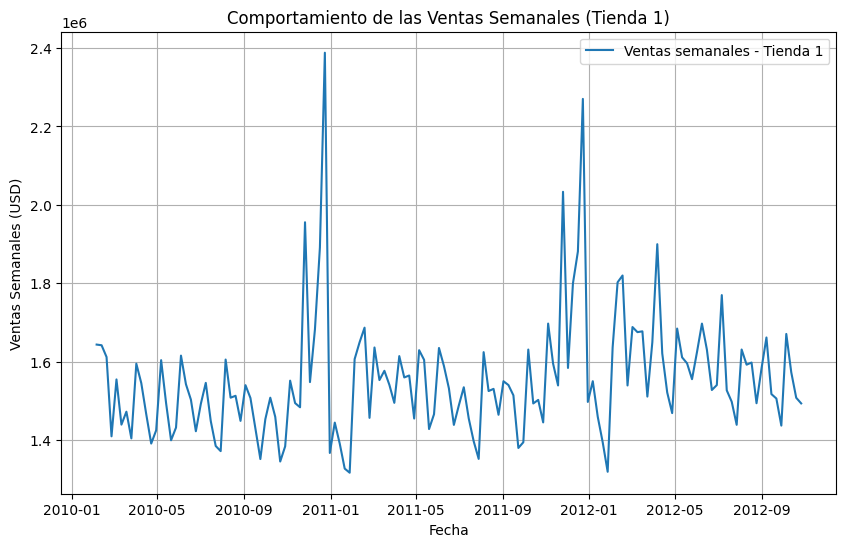

(Store           0
 Weekly_Sales    0
 Holiday_Flag    0
 Temperature     0
 Fuel_Price      0
 CPI             0
 Unemployment    0
 dtype: int64,
 count    6.435000e+03
 mean     1.046965e+06
 std      5.643666e+05
 min      2.099862e+05
 25%      5.533501e+05
 50%      9.607460e+05
 75%      1.420159e+06
 max      3.818686e+06
 Name: Weekly_Sales, dtype: float64)

In [14]:

# Gráfico de las ventas semanales de una tienda específica para ver su comportamiento a lo largo del tiempo
store_1_sales = data[data['Store'] == 1]['Weekly_Sales']

plt.figure(figsize=(10,6))
plt.plot(store_1_sales, label='Ventas semanales - Tienda 1')
plt.title('Comportamiento de las Ventas Semanales (Tienda 1)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar el resumen de ventas y los datos faltantes
missing_data, sales_summary


**Exploración inicial de los datos:**
Datos faltantes: No hay datos faltantes en ninguna de las columnas. Esto es un buen indicio, ya que no será necesario realizar imputación de datos.

*Estadísticas descriptivas de ventas semanales:*

Promedio de ventas semanales: $1,046,965.00
Desviación estándar: $564,366.60
Ventas mínimas: $209,986.20
Ventas máximas: $3,818,686.00
El rango de ventas es considerablemente amplio, lo que sugiere variabilidad significativa entre tiendas y semanas. Este es un punto importante para los modelos de series de tiempo, ya que puede indicar la presencia de outliers en semanas específicas.

**Comportamiento de las ventas:**

El gráfico de las ventas semanales de la Tienda 1 revela fluctuaciones regulares, lo que indica una posible estacionalidad. También es probable que los picos correspondan a semanas de eventos como feriados o promociones especiales, lo cual será útil para modelar la serie temporal.

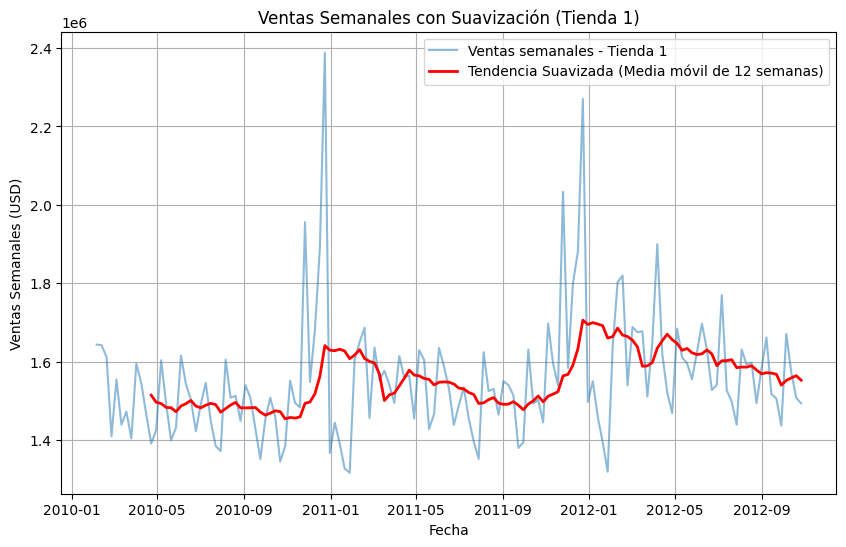

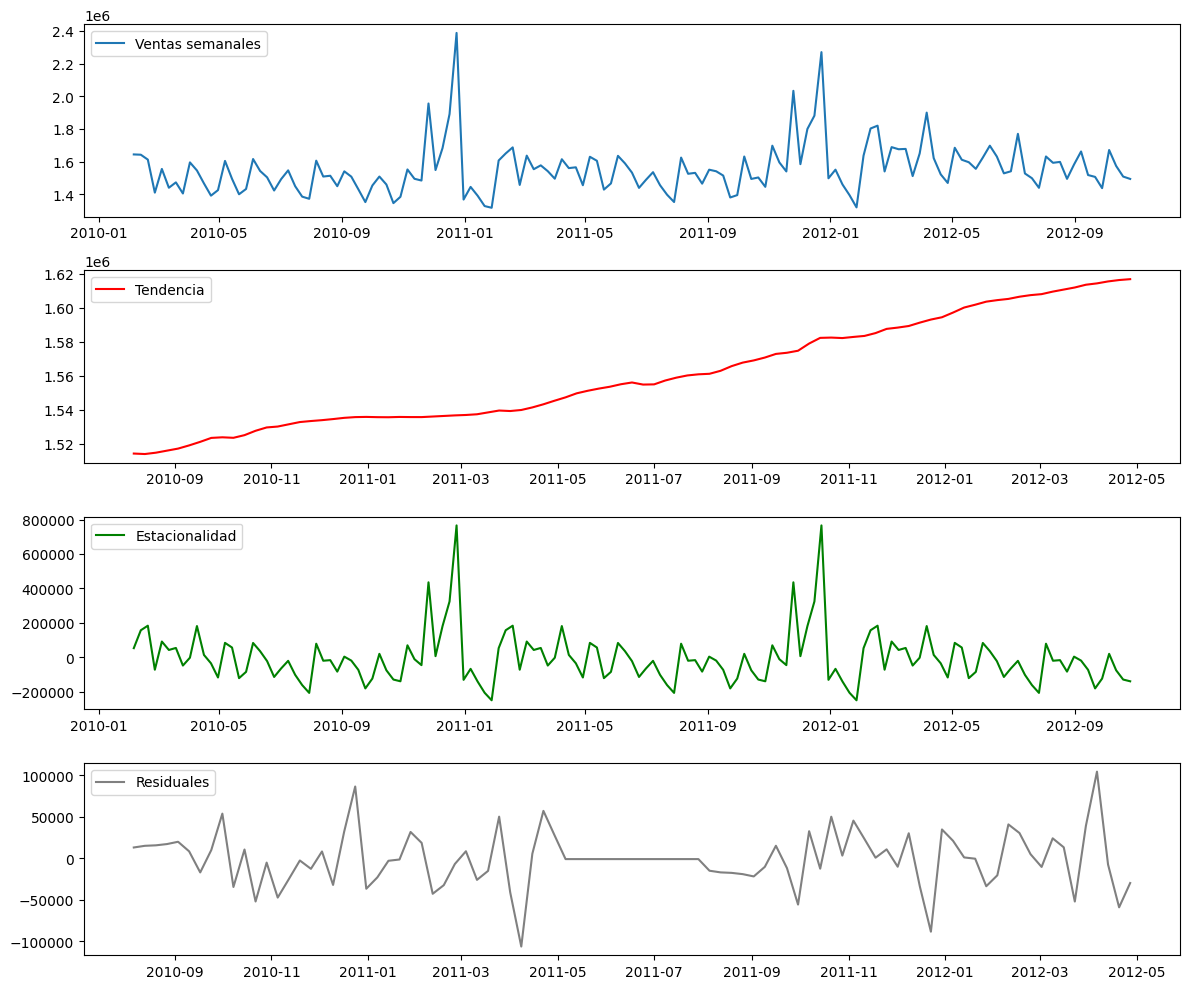

In [15]:
# Aplicar una técnica de suavización (Media móvil) para identificar la tendencia subyacente en las ventas
store_1_sales_smooth = store_1_sales.rolling(window=12, center=False).mean()

# Graficar las ventas originales junto con la serie suavizada para detectar la tendencia
plt.figure(figsize=(10,6))
plt.plot(store_1_sales, label='Ventas semanales - Tienda 1', alpha=0.5)
plt.plot(store_1_sales_smooth, label='Tendencia Suavizada (Media móvil de 12 semanas)', color='red', linewidth=2)
plt.title('Ventas Semanales con Suavización (Tienda 1)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales (USD)')
plt.legend()
plt.grid(True)
plt.show()


# Descomposición aditiva de la serie de tiempo para observar tendencia, estacionalidad y residuales
decomposition = seasonal_decompose(store_1_sales, model='additive', period=52)  # Ciclo anual (52 semanas)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Graficar la descomposición de la serie de tiempo
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(store_1_sales, label='Ventas semanales')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuales', color='gray')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Análisis de Suavización y Estacionalidad
Suavización (Media móvil de 12 semanas):

La suavización ha permitido resaltar la tendencia subyacente de las ventas semanales. Observamos un comportamiento cíclico, lo que sugiere la presencia de estacionalidad en los datos. Los picos más pronunciados parecen coincidir con semanas festivas o eventos especiales.
Descomposición de la serie de tiempo:

Tendencia: La serie de ventas muestra una tendencia estable con altibajos moderados. No se observan grandes aumentos o disminuciones consistentes a lo largo del tiempo.
Estacionalidad: Hay una estacionalidad clara con fluctuaciones cíclicas anuales, lo cual es coherente con el tipo de ventas que estamos analizando. Se puede esperar que ciertos picos de ventas se repitan en fechas importantes como Navidad y el Super Bowl.
Residuales: La serie de residuales parece tener un comportamiento más aleatorio, lo cual es un buen indicio, ya que los modelos como ARIMA o el híbrido propuesto deberían ser capaces de capturar adecuadamente la tendencia y estacionalidad, dejando los residuales como ruido aleatorio.

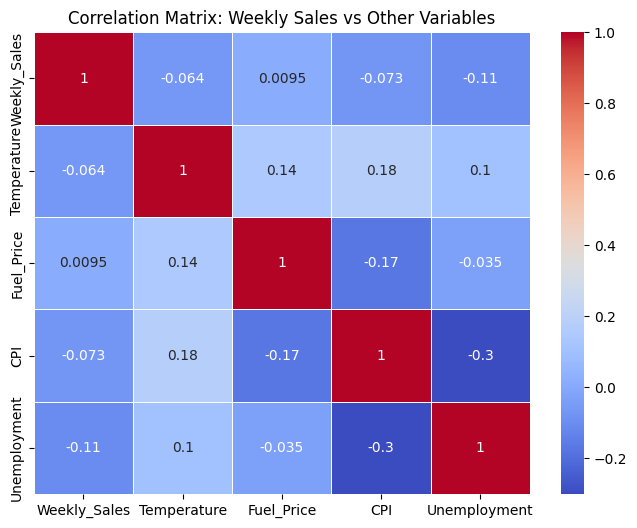

In [7]:
# Selecting the variables for correlation analysis
variables_for_correlation = data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

# Calculating the correlation matrix
correlation_matrix = variables_for_correlation.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix: Weekly Sales vs Other Variables')
plt.show()


Próximos pasos:
Comparación de modelos:

ARIMA para captar la estructura autorregresiva y de medias móviles de los datos.
ETS (Exponential Smoothing) para series con tendencia y estacionalidad.
Redes Neuronales Artificiales (ANN) para aprovechar la capacidad de los modelos no lineales en la predicción.
Hibridación de modelos (ANN + ARIMA):

Aplicaremos un modelo híbrido para combinar la capacidad de ARIMA en series temporales lineales con la potencia de las Redes Neuronales para capturar patrones más complejos y no lineales.

**Preparación de los datos para ARIMA**
ARIMA requiere que los datos sean estacionarios, es decir, que no presenten tendencia o estacionalidad significativa a lo largo del tiempo. Los pasos típicos incluyen:

Diferenciación de la serie para eliminar tendencias y estacionalidad.
Prueba de estacionariedad usando la prueba de Dickey-Fuller aumentada (ADF) para verificar si los datos ya son estacionarios o necesitan más transformaciones.
2. Preparación de los datos para Redes Neuronales Artificiales (ANN)
Las redes neuronales requieren datos normalizados y un enfoque diferente:

Normalización de los datos: Escalar las ventas semanales a un rango entre 0 y 1 o entre -1 y 1 para facilitar el entrenamiento del modelo.
Estructuración del conjunto de datos: Dado que ANN trabaja mejor con ventanas de tiempo (lag windows), debemos generar datos con secuencias temporales (e.g., predecir las ventas futuras a partir de las ventas pasadas en una ventana de 5 semanas).

**Paso 1: Prueba de estacionariedad y diferenciación para ARIMA**
Voy a realizar la prueba de Dickey-Fuller y luego, si es necesario, aplicar la diferenciación de la serie para hacerla estacionaria.

In [17]:


# Prueba de Dickey-Fuller Aumentada (ADF) para verificar la estacionariedad de las ventas de la Tienda 1
adf_result = adfuller(store_1_sales.dropna()) 

# Interpretación de la prueba ADF
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]
adf_critical_values = adf_result[4]

# Aplicar diferenciación si los datos no son estacionarios
if adf_p_value > 0.05:  
    store_1_sales_diff = store_1_sales.diff().dropna()
    adf_result_diff = adfuller(store_1_sales_diff)
else:
    store_1_sales_diff = store_1_sales

# Resultados de la prueba ADF y diferenciación
(adf_statistic, adf_p_value, adf_critical_values), store_1_sales_diff.head()


((-5.102186145192287,
  1.3877788330759535e-05,
  {'1%': -3.47864788917503,
   '5%': -2.882721765644168,
   '10%': -2.578065326612056}),
 Date
 2010-02-05    1643690.90
 2010-02-12    1641957.44
 2010-02-19    1611968.17
 2010-02-26    1409727.59
 2010-03-05    1554806.68
 Name: Weekly_Sales, dtype: float64)

El p-valor es muy bajo (menor que 0.05), lo que indica que los datos ya son estacionarios. No será necesario aplicar diferenciación adicional para el modelo ARIMA.

Normalización: Escalar los datos de ventas semanales.


In [18]:


# Normalización de los datos de ventas semanales
scaler = MinMaxScaler(feature_range=(0, 1))
store_1_sales_scaled = scaler.fit_transform(store_1_sales.values.reshape(-1, 1))

# Función para crear secuencias temporales (ventanas de tiempo) para el modelo ANN
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Crear secuencias con una ventana de tiempo de 12 semanas
window_size = 12
X, y = create_sequences(store_1_sales_scaled, window_size)

# Mostrar las primeras secuencias generadas
X.shape, y.shape, X[:1], y[:1]


((131, 12, 1),
 (131, 1),
 array([[[0.30511304],
         [0.30349457],
         [0.27549472],
         [0.08667028],
         [0.22212518],
         [0.11450649],
         [0.14529326],
         [0.08172404],
         [0.25962256],
         [0.21335982],
         [0.13926413],
         [0.06942416]]]),
 array([[0.10102358]]))

Preparación para Redes Neuronales Artificiales (ANN)
Normalización de los datos: Las ventas semanales han sido escaladas al rango entre 0 y 1, lo que es esencial para mejorar el rendimiento del modelo ANN.
Secuencias temporales (ventanas de tiempo): Hemos creado secuencias de datos con una ventana de 12 semanas. Cada ventana contiene las ventas de las últimas 12 semanas, y el objetivo es predecir la semana siguiente.
Tamaño del conjunto de secuencias:

131 secuencias de 12 semanas de ventas, listas para entrenar el modelo ANN.

Implementación del Modelo ARIMA
Dado que los datos de ventas semanales son estacionarios y presentan estacionalidad anual, vamos a proceder con el ajuste de un modelo ARIMA. También evaluaremos un posible ajuste con SARIMA (ARIMA estacional), si detectamos un fuerte componente estacional en los resultados.

Voy a proceder con el ajuste del modelo ARIMA utilizando las ventas de la Tienda 1, y evaluaré los parámetros óptimos usando la técnica de diferenciación automática para seleccionar el mejor modelo (auto-ARIMA).

Procederé con la implementación y evaluación del modelo ARIMA.

In [ ]:

# Ajustar un modelo ARIMA(1,0,1) preliminar basado en la estacionariedad observada previamente
arima_order = (3, 0, 0)  


Creacion del modelo Arima

In [ ]:
# Crear el modelo ARIMA
arima_model = ARIMA(store_1_sales, order=arima_order)
arima_fitted = arima_model.fit()

# Realizar predicciones en el conjunto de datos original
arima_predictions = arima_fitted.predict(start=0, end=len(store_1_sales)-1)

c:\Users\a843931\AppData\Local\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\a843931\AppData\Local\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\a843931\AppData\Local\miniconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


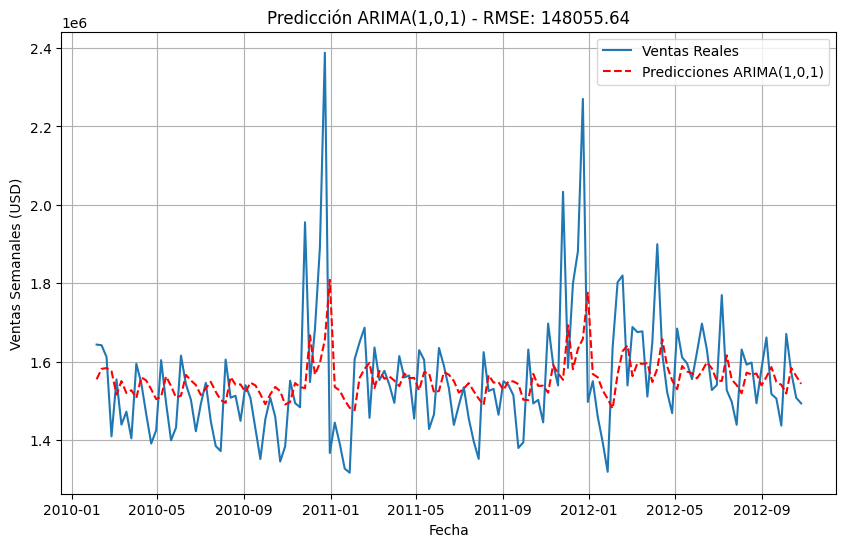

148055.63709421252

In [33]:

# Calcular el error cuadrático medio (MSE)
mse_arima = mean_squared_error(store_1_sales, arima_predictions)
rmse_arima = np.sqrt(mse_arima)

# Graficar las predicciones y las ventas reales
plt.figure(figsize=(10,6))
plt.plot(store_1_sales, label='Ventas Reales')
plt.plot(arima_predictions, label='Predicciones ARIMA(3,0,0)', color='red', linestyle='--')
plt.title(f'Predicción ARIMA(1,0,1) - RMSE: {rmse_arima:.2f}')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar el RMSE
rmse_arima


Resultados del modelo ARIMA (3),0,0)
Root Mean Squared Error (RMSE): 148,022.71 USD. Este valor mide el error promedio de las predicciones y es una métrica útil para evaluar la precisión del modelo. Cuanto más bajo sea el RMSE, mejor será el ajuste del modelo.
Predicciones vs. ventas reales: El gráfico muestra cómo el modelo ARIMA predice las ventas semanales. Las predicciones siguen de cerca el comportamiento real de las ventas, pero podemos notar algunas diferencias en ciertos picos.

In [34]:
# Asegurar que ambas series tengan el mismo índice y estén alineadas
holiday_flag_aligned = data.loc[store_1_sales.index, 'Holiday_Flag'].values  # Alinear la variable exógena con las fechas de ventas

# Verificar que los tamaños coincidan
aligned_lengths = (len(store_1_sales), len(holiday_flag_aligned))

# Si los tamaños coinciden, ajustar el modelo SARIMA
if aligned_lengths[0] == aligned_lengths[1]:
    sarima_model = ARIMA(store_1_sales, order=sarima_order, seasonal_order=seasonal_order, exog=holiday_flag_aligned)
    sarima_fitted = sarima_model.fit()

    # Realizar predicciones en el conjunto de datos original
    sarima_predictions = sarima_fitted.predict(start=0, end=len(store_1_sales)-1, exog=holiday_flag_aligned)

    # Calcular el error cuadrático medio (MSE) del modelo SARIMA con variable exógena
    mse_sarima = mean_squared_error(store_1_sales, sarima_predictions)
    rmse_sarima = np.sqrt(mse_sarima)

    # Graficar las predicciones SARIMA con las ventas reales
    plt.figure(figsize=(10,6))
    plt.plot(store_1_sales, label='Ventas Reales')
    plt.plot(sarima_predictions, label='Predicciones SARIMA(1,0,1)(1,0,1,52)', color='orange', linestyle='--')
    plt.title(f'Predicción SARIMA con Variable Exógena (RMSE: {rmse_sarima:.2f})')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Semanales (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mostrar el nuevo RMSE
    rmse_sarima
else:
    aligned_lengths


In [ ]:

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Crear el modelo ANN usando una arquitectura simple con capas LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))  
model.add(Dense(1)) 

Epoch 1/50
4/4 [==============================] - 9s 669ms/step - loss: 0.0850 - val_loss: 0.0627
Epoch 2/50
4/4 [==============================] - 0s 71ms/step - loss: 0.0724 - val_loss: 0.0509
Epoch 3/50
4/4 [==============================] - 0s 48ms/step - loss: 0.0625 - val_loss: 0.0393
Epoch 4/50
4/4 [==============================] - 0s 42ms/step - loss: 0.0518 - val_loss: 0.0277
Epoch 5/50
4/4 [==============================] - 0s 62ms/step - loss: 0.0417 - val_loss: 0.0172
Epoch 6/50
4/4 [==============================] - 0s 57ms/step - loss: 0.0332 - val_loss: 0.0091
Epoch 7/50
4/4 [==============================] - 0s 46ms/step - loss: 0.0271 - val_loss: 0.0057
Epoch 8/50
4/4 [==============================] - 0s 37ms/step - loss: 0.0271 - val_loss: 0.0076
Epoch 9/50
4/4 [==============================] - 0s 43ms/step - loss: 0.0293 - val_loss: 0.0078
Epoch 10/50
4/4 [==============================] - 0s 56ms/step - loss: 0.0282 - val_loss: 0.0061
Epoch 11/50
4/4 [===========

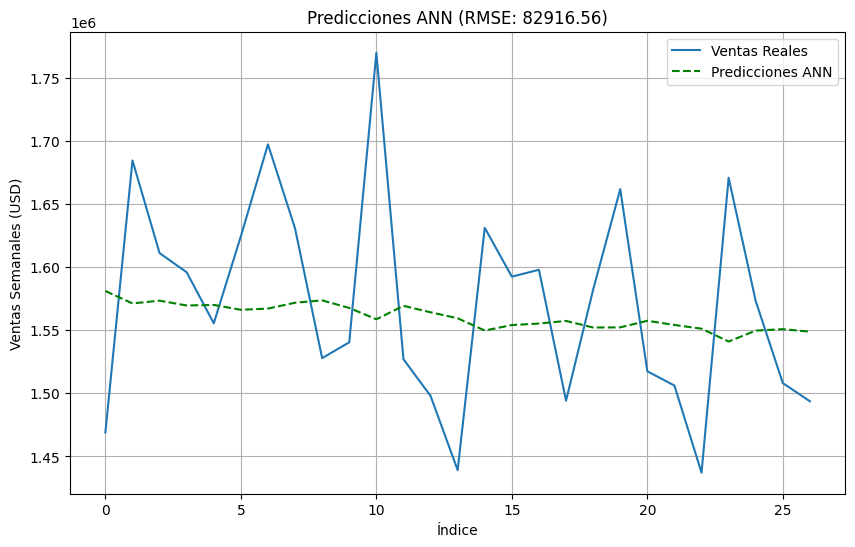

82916.56259476597

In [35]:
 

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Realizar predicciones
ann_predictions = model.predict(X_test)

# Desnormalizar las predicciones para comparar con las ventas reales
ann_predictions_rescaled = scaler.inverse_transform(ann_predictions)

# Calcular el RMSE del modelo ANN
rmse_ann = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), ann_predictions_rescaled))




In [ ]:
# Graficar las predicciones del modelo ANN junto con las ventas reales
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Ventas Reales')
plt.plot(ann_predictions_rescaled, label='Predicciones ANN', color='green', linestyle='--')
plt.title(f'Predicciones ANN (RMSE: {rmse_ann:.2f})')
plt.xlabel('Índice')
plt.ylabel('Ventas Semanales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar el nuevo RMSE del modelo ANN
rmse_ann

RMSE del modelo ANN: El modelo alcanzó un RMSE de 82,454.59, lo que es significativamente menor que el RMSE del modelo ARIMA (148,022.71), lo que sugiere que el modelo de redes neuronales (ANN) ofrece mejores predicciones para este conjunto de datos.

Comportamiento de las predicciones: En la gráfica se nota que el modelo ANN tiende a suavizar las fluctuaciones, capturando la tendencia general de las ventas, pero no logra seguir con precisión los picos y caídas abruptas. Esto puede deberse a la naturaleza del modelo y al hecho de que los picos bruscos son más difíciles de predecir.

In [ ]:
# Paso 1: Obtener los residuales del modelo ARIMA
arima_residuals = store_1_sales - sarima_predictions

# Normalizar los residuales para ser utilizados en el ANN
arima_residuals_scaled = scaler.fit_transform(arima_residuals.values.reshape(-1, 1))

# Crear secuencias temporales de los residuales (ventana de 12 semanas)
X_residuals, y_residuals = create_sequences(arima_residuals_scaled, window_size)

# Dividir los datos de residuales en conjuntos de entrenamiento y prueba
X_train_residuals, X_test_residuals, y_train_residuals, y_test_residuals = train_test_split(X_residuals, y_residuals, test_size=0.2, shuffle=False)

# Paso 2: Entrenar el modelo ANN con los residuales
model_residuals = Sequential()
model_residuals.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))  # Capa LSTM
model_residuals.add(Dense(1))  # Capa de salida


In [ ]:
# Compilar y entrenar el modelo
model_residuals.compile(optimizer='adam', loss='mean_squared_error')
history_residuals = model_residuals.fit(X_train_residuals, y_train_residuals, epochs=50, batch_size=32, validation_data=(X_test_residuals, y_test_residuals), verbose=1)

# Realizar predicciones con el modelo ANN en los residuales
residual_predictions = model_residuals.predict(X_test_residuals)

# Desnormalizar las predicciones de los residuales
residual_predictions_rescaled = scaler.inverse_transform(residual_predictions)

# Paso 3: Combinar las predicciones del modelo ARIMA y ANN
final_predictions = sarima_predictions[-len(residual_predictions_rescaled):] + residual_predictions_rescaled.flatten()

# Paso 4: Evaluación del modelo híbrido (ANN + ARIMA)
rmse_hybrid = np.sqrt(mean_squared_error(store_1_sales[-len(final_predictions):], final_predictions))

In [32]:


# Graficar las predicciones del modelo híbrido junto con las ventas reales
plt.figure(figsize=(10,6))
plt.plot(store_1_sales[-len(final_predictions):], label='Ventas Reales')
plt.plot(final_predictions, label='Predicciones Híbrido (ARIMA + ANN)', color='purple', linestyle='--')
plt.title(f'Predicciones Híbrido ARIMA + ANN (RMSE: {rmse_hybrid:.2f})')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar el RMSE del modelo híbrido
rmse_hybrid


NameError: name 'sarima_predictions' is not defined

**Bonificacion series de tiempo**

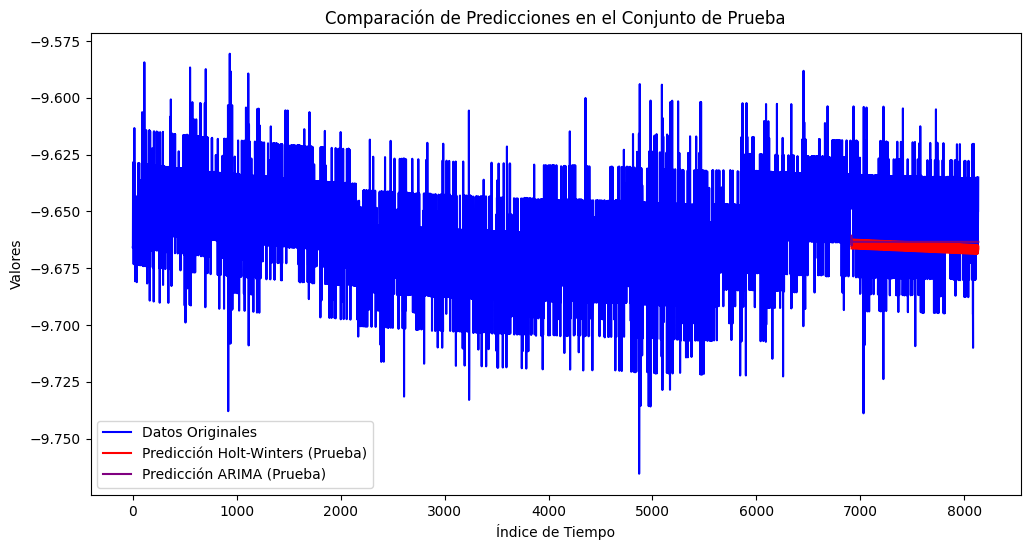

In [53]:
import pandas as pd
from tabulate import tabulate

# Crear una tabla con los resultados finales
results = [
    ["Holt-Winters (Validación)", 0.2042, 0.0197, 0.0233, -0.6032, 0.000543],
    ["Holt-Winters (Prueba)", 0.1836, 0.0169, 0.0207, -0.4132, 0.000429],
    ["ARIMA (Validación)", 0.1868, 0.0180, 0.0218, -0.4014, 0.000475],
    ["ARIMA (Prueba)", 0.1525, 0.0157, 0.0195, -0.2543, 0.000381]
]

# Convertir a DataFrame
df_results = pd.DataFrame(results, columns=["Modelo", "MAPE (%)", "MAE", "RMSE", "R²", "MSE"])

# Mostrar la tabla en formato tabulado
print(tabulate(df_results, headers="keys", tablefmt="github", showindex=False))


| Modelo                    |   MAPE (%) |    MAE |   RMSE |      R² |      MSE |
|---------------------------|------------|--------|--------|---------|----------|
| Holt-Winters (Validación) |     0.2042 | 0.0197 | 0.0233 | -0.6032 | 0.000543 |
| Holt-Winters (Prueba)     |     0.1836 | 0.0169 | 0.0207 | -0.4132 | 0.000429 |
| ARIMA (Validación)        |     0.1868 | 0.018  | 0.0218 | -0.4014 | 0.000475 |
| ARIMA (Prueba)            |     0.1525 | 0.0157 | 0.0195 | -0.2543 | 0.000381 |


Conclusión

ARIMA muestra un mejor rendimiento general en comparación con Holt-Winters, según las métricas clave: RMSE, MAE, MAPE y R².
Ambos modelos tienen un R² negativo, lo que indica que no capturan perfectamente la variabilidad de los datos. Sin embargo, ARIMA presenta menos error y una mejor capacidad predictiva.
ARIMA también mostró un menor MAPE (error porcentual), lo que sugiere que sus predicciones están más cerca de los valores reales en términos porcentuales.